In [1]:
import os
os.chdir('../../')

In [2]:
import pandas as pd
import re
from google.oauth2 import service_account
from google.cloud import bigquery
%matplotlib inline

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [5]:
SERVICE_ACCOUNT = 'private/bigquery-write-access.json'
DATASET = 'student_counts'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT)

In [6]:
bqclient = bigquery.Client(project=credentials.project_id, credentials=credentials)

## Read Data

In [7]:
query_string = \
"""
SELECT 
    year,
	source_country,
	destination_country,
	--dst_distance,
	dst_students_count as dst_st_cnt,
	dst_average_wage,
	dst_rate_of_one_usd as dst_rate_1_usd,
	dst_cpi,
	--dst_qoe_top20,
	dst_qoe_top100,
	--dst_qoe_top200,
	--dst_qoe_top500,
	src_population,
	--src_qoe_top20,
	--src_qoe_top100,
	--src_qoe_top200,
	src_qoe_top500,
	src_gni,
	src_gdp,
	--src_rate_of_one_usd,
	src_tertiary_enrolment as src_tertiary_enrol

FROM `int-stud-mobility-drivers.datasets_for_modelling.students_by_year_countrly_all_predictors` 
"""
raw_dataframe = bqclient.query(query_string).result().to_dataframe()
raw_dataframe['src_gdp'] = raw_dataframe['src_gdp'] / 1e9
raw_dataframe['src_population'] = raw_dataframe['src_population'] / 1e6
raw_dataframe['dst_average_wage'] = raw_dataframe['dst_average_wage'] / 1000
#raw_dataframe['dst_distance'] = raw_dataframe['dst_distance'] / 1000

country_codes = {
    "Australia": 'aus', 
    'Canada': 'can', 
    'United Kingdom': 'uk',
    'United States of America': 'us',
    'New Zealand': 'nz'
}
destination_col = 'destination_code'
raw_dataframe[destination_col] = raw_dataframe.destination_country.apply(lambda x: country_codes[x])

dataframe = raw_dataframe.copy()

In [8]:
raw_dataframe.head()

,year,source_country,destination_country,dst_st_cnt,dst_average_wage,dst_rate_1_usd,dst_cpi,dst_qoe_top100,src_population,src_qoe_top500,src_gni,src_gdp,src_tertiary_enrol,destination_code
0,1998,China,Australia,4132,45.034,1.591828,70.161290,0,1241.935,0,800.0,1030.0,5.95095,aus
1,1999,China,Australia,4578,45.564,1.549950,71.201873,0,1252.735,0,860.0,1090.0,6.45695,aus
2,2000,China,Australia,5008,45.459,1.724827,74.375650,0,1262.645,4,940.0,1210.0,7.62093,aus
3,2002,China,Australia,17343,46.270,1.840563,79.968783,1,1280.400,8,1110.0,1470.0,12.50686,aus
4,2003,China,Australia,23448,46.811,1.541914,82.154006,1,1288.400,12,1280.0,1660.0,15.24153,aus


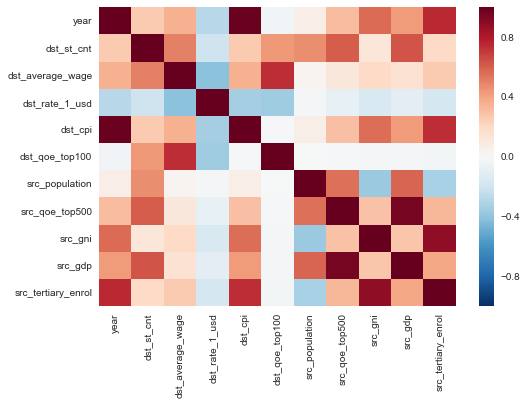

In [9]:
corr = dataframe.corr()
sns.heatmap(corr)
plt.show()

In [10]:
dataframe = dataframe[dataframe.source_country == 'China']
#dataframe = dataframe[dataframe.destination_country == 'Canada']

In [11]:
index_cols = ['source_country', 'year']
dst_cols = [col for col in dataframe.columns if col.startswith('dst')]
src_cols = [col for col in dataframe.columns if col.startswith('src')]

## Transform Destination Country Variables 

In [12]:
dest_index = index_cols + [destination_col]
dest_df = dataframe[dest_index + dst_cols].copy()
dest_df.set_index(dest_index, inplace=True)
dest_df.head()

dst_st_cnt  dst_average_wage  \
source_country year destination_code                                 
China          1998 aus                     4132            45.034   
               1999 aus                     4578            45.564   
               2000 aus                     5008            45.459   
               2002 aus                    17343            46.270   
               2003 aus                    23448            46.811   

                                      dst_rate_1_usd    dst_cpi  \
source_country year destination_code                              
China          1998 aus                     1.591828  70.161290   
               1999 aus                     1.549950  71.201873   
               2000 aus                     1.724827  74.375650   
               2002 aus                     1.840563  79.968783   
               2003 aus                     1.541914  82.154006   

                                      dst_qoe_top100  
source_country year destination_code                  
China          1998 aus                            0  
               1999 aus                            0  
               2000 aus                            0  
               2002 aus                            1  
               2003 aus                            1

In [13]:
dest_df = dest_df.unstack(level=destination_col)
dest_df.head()

dst_st_cnt                                     \
destination_code           aus      can      nz       uk       us   
source_country year                                                 
China          1998     4132.0   2820.0    78.0   2877.0  43000.0   
               1999     4578.0   3489.0   247.0   4250.0  46949.0   
               2000     5008.0   4701.0  1133.0   6158.0  50281.0   
               2001    11175.0   6972.0  3338.0  10388.0  51986.0   
               2002    17343.0  10176.0  8481.0  17483.0  63211.0   

                    dst_average_wage                                  \
destination_code                 aus     can      nz      uk      us   
source_country year                                                    
China          1998           45.034  37.289  31.643  41.623  53.148   
               1999           45.564  37.939  32.192  41.818  53.649   
               2000           45.459  39.380  31.806  38.908  53.904   
               2001           45.953  39.218  32.391  40.840  54.360   
               2002           46.270  38.800  33.005  41.517  54.788   

                    dst_rate_1_usd                                     \
destination_code               aus       can        nz        uk   us   
source_country year                                                     
China          1998       1.591828  1.483505  1.868249  0.603824  1.0   
               1999       1.549950  1.485705  1.889614  0.618057  1.0   
               2000       1.724827  1.485394  2.201149  0.660931  1.0   
               2001       1.933442  1.548840  2.378751  0.694655  1.0   
               2002       1.840563  1.570343  2.162191  0.667223  1.0   

                       dst_cpi                                              \
destination_code           aus        can         nz         uk         us   
source_country year                                                          
China          1998  70.161290  78.362908  75.121615  79.128907  74.755433   
               1999  71.201873  79.722381  75.035776  80.515998  76.391102   
               2000  74.375650  81.890384  76.998137  81.468467  78.970721   
               2001  77.653486  83.958214  79.019967  82.716849  81.202568   
               2002  79.968783  85.854322  81.135405  83.974478  82.490467   

                    dst_qoe_top100                        
destination_code               aus  can   nz    uk    us  
source_country year                                       
China          1998            0.0  4.0  0.0  12.0  57.0  
               1999            0.0  4.0  0.0  13.0  57.0  
               2000            0.0  4.0  0.0  13.0  56.0  
               2001            1.0  4.0  0.0  13.0  56.0  
               2002            1.0  4.0  0.0  13.0  56.0

In [14]:
dest_df.columns = ['{}_{}'.format(var, code) for var, code in dest_df.columns.values]

In [15]:
#dest_df.head()

## Source Country Variables

In [16]:
source_df = dataframe[index_cols + src_cols].copy().drop_duplicates()
source_df.set_index(index_cols, inplace=True)
#source_df.head()

## Join source and destination predictors

In [17]:
dataset_df = pd.concat([source_df, dest_df], sort=False, axis=1)
dataset_df

src_population  src_qoe_top500  src_gni  src_gdp  \
source_country year                                                     
China          1998        1241.935               0    800.0   1030.0   
               1999        1252.735               0    860.0   1090.0   
               2000        1262.645               4    940.0   1210.0   
               2001        1271.850               5   1010.0   1340.0   
               2002        1280.400               8   1110.0   1470.0   
               2003        1288.400              12   1280.0   1660.0   
               2004        1296.075              16   1510.0   1960.0   
               2005        1303.720              18   1760.0   2290.0   
               2006        1311.020              19   2060.0   2750.0   
               2007        1317.885              25   2510.0   3550.0   
               2008        1324.655              30   3100.0   4590.0   
               2009        1331.260              30   3680.0   5100.0   
               2010        1337.705              34   4340.0   6090.0   
               2011        1344.130              35   5050.0   7550.0   
               2012        1350.695              42   5930.0   8530.0   
               2013        1357.380              42   6770.0   9570.0   
               2014        1364.270              44   7500.0  10400.0   
               2015        1371.220              44   7910.0  11000.0   
               2016        1378.665              54   8210.0  11100.0   
               2017        1386.395              57   8630.0  12100.0   

                     src_tertiary_enrol  dst_st_cnt_aus  dst_st_cnt_can  \
source_country year                                                       
China          1998            5.950950          4132.0          2820.0   
               1999            6.456950          4578.0          3489.0   
               2000            7.620930          5008.0          4701.0   
               2001            9.767590         11175.0          6972.0   
               2002           12.506860         17343.0         10176.0   
               2003           15.241530         23448.0         14592.0   
               2004           17.440081         28309.0         18141.0   
               2005           18.849369         37344.0         19752.0   
               2006           20.044500         42008.0         12279.0   
               2007           20.460840         50418.0         21081.0   
               2008           20.672791         57596.0         19961.0   
               2009           22.398729         70357.0         23619.0   
               2010           24.050310         87588.0         26298.0   
               2011           25.292101         90175.0         26238.0   
               2012           28.035191         87497.0         34602.0   
               2013           31.459860         87980.0         42011.0   
               2014           41.277729         90245.0         50031.0   
               2015           45.350719         97387.0         54660.0   
               2016           48.441051        112329.0         60936.0   
               2017           51.006741        128498.0             NaN   

                     dst_st_cnt_nz  dst_st_cnt_uk  dst_st_cnt_us  \
source_country year                                                
China          1998           78.0         2877.0        43000.0   
               1999          247.0         4250.0        46949.0   
               2000         1133.0         6158.0        50281.0   
               2001         3338.0        10388.0        51986.0   
               2002         8481.0        17483.0        63211.0   
               2003        16479.0        30690.0        92774.0   
               2004        24215.0        47738.0        87943.0   
               2005        23260.0        52677.0        92370.0   
               2006        18300.0        50753.0        93672.0   
               

In [18]:
table_full_name = '{}.{}'.format('datasets_for_modelling', 'students_by_year_countrly_transformed')
dataset_df.to_gbq(table_full_name, credentials.project_id, credentials=credentials, if_exists='replace')

1it [00:05,  5.70s/it]


In [19]:
#dataset_df.info()

In [20]:
dataset_df.dropna(inplace=True)

In [21]:
%load_ext rpy2.ipython

## Modelling

### Multinomial (src_country predictors)

In [22]:
dataset_df

src_population  src_qoe_top500  src_gni  src_gdp  \
source_country year                                                     
China          1998        1241.935               0    800.0   1030.0   
               1999        1252.735               0    860.0   1090.0   
               2000        1262.645               4    940.0   1210.0   
               2001        1271.850               5   1010.0   1340.0   
               2002        1280.400               8   1110.0   1470.0   
               2003        1288.400              12   1280.0   1660.0   
               2004        1296.075              16   1510.0   1960.0   
               2005        1303.720              18   1760.0   2290.0   
               2006        1311.020              19   2060.0   2750.0   
               2007        1317.885              25   2510.0   3550.0   
               2008        1324.655              30   3100.0   4590.0   
               2009        1331.260              30   3680.0   5100.0   
               2010        1337.705              34   4340.0   6090.0   
               2011        1344.130              35   5050.0   7550.0   
               2012        1350.695              42   5930.0   8530.0   
               2013        1357.380              42   6770.0   9570.0   
               2014        1364.270              44   7500.0  10400.0   
               2015        1371.220              44   7910.0  11000.0   
               2016        1378.665              54   8210.0  11100.0   

                     src_tertiary_enrol  dst_st_cnt_aus  dst_st_cnt_can  \
source_country year                                                       
China          1998            5.950950          4132.0          2820.0   
               1999            6.456950          4578.0          3489.0   
               2000            7.620930          5008.0          4701.0   
               2001            9.767590         11175.0          6972.0   
               2002           12.506860         17343.0         10176.0   
               2003           15.241530         23448.0         14592.0   
               2004           17.440081         28309.0         18141.0   
               2005           18.849369         37344.0         19752.0   
               2006           20.044500         42008.0         12279.0   
               2007           20.460840         50418.0         21081.0   
               2008           20.672791         57596.0         19961.0   
               2009           22.398729         70357.0         23619.0   
               2010           24.050310         87588.0         26298.0   
               2011           25.292101         90175.0         26238.0   
               2012           28.035191         87497.0         34602.0   
               2013           31.459860         87980.0         42011.0   
               2014           41.277729         90245.0         50031.0   
               2015           45.350719         97387.0         54660.0   
               2016           48.441051        112329.0         60936.0   

                     dst_st_cnt_nz  dst_st_cnt_uk  dst_st_cnt_us  \
source_country year                                                
China          1998           78.0         2877.0        43000.0   
               1999          247.0         4250.0        46949.0   
               2000         1133.0         6158.0        50281.0   
               2001         3338.0        10388.0        51986.0   
               2002         8481.0        17483.0        63211.0   
               2003        16479.0        30690.0        92774.0   
               2004        24215.0        47738.0        87943.0   
               2005        23260.0        52677.0        92370.0   
               2006        18300.0        50753.0        93672.0   
               2007        13535.0        49594.0        98958.0   
               2008         9859.0        45356.0       110246.0   
               2009        

In [23]:
response_cols = [item for item in dataset_df.columns if item.startswith('dst_st_cnt')]
predictor_cols = [item for item in dataset_df.columns if item not in response_cols]
#predictor_cols = [item for item in dataset_df.columns if item.startswith('src')]

In [24]:
df = dataset_df.reset_index()
response_df = df[response_cols].astype(int)
predictors_df = df[predictor_cols]

In [25]:
%%R -i response_df -i predictors_df
library(nnet)
p_ = as.matrix(predictors_df)
model = multinom(as.matrix(response_df) ~ p_)

# weights:  135 (104 variable)
initial  value 8279940.035315 
iter  10 value 6849491.969946
iter  20 value 6786408.001254
iter  30 value 6783017.413622
iter  40 value 6781508.609620
iter  50 value 6780726.742445
iter  60 value 6777868.247858
iter  70 value 6709529.044105
iter  80 value 6681420.371895
final  value 6681237.304504 
converged


In [26]:
%%R
coefs = round((t(coef(model))), 4)
#names = dimnames(coefs)
coefs

                       dst_st_cnt_can dst_st_cnt_nz dst_st_cnt_uk dst_st_cnt_us
(Intercept)                    1.5335       -0.0587        0.1960        0.6091
p_src_population               0.0744       -0.0517       -0.0069        0.0354
p_src_qoe_top500              -0.2973       -0.0507       -0.0502       -0.2008
p_src_gni                     -0.0082       -0.0005       -0.0007        0.0007
p_src_gdp                      0.0058       -0.0011        0.0002        0.0007
p_src_tertiary_enrol          -0.1026       -0.2573       -0.0796       -0.1316
p_dst_average_wage_aus        -1.3278       -0.3251       -0.3128       -0.7270
p_dst_average_wage_can        -0.3185        0.1364        0.0408       -0.7361
p_dst_average_wage_nz          2.4504        0.1112        0.1095        0.7202
p_dst_average_wage_uk         -1.0791       -0.1487       -0.1511       -0.5071
p_dst_average_wage_us         -0.1481       -0.1205        0.1454        0.3239
p_dst_rate_1_usd_aus          -4.9535   

In [27]:
%R -o coefs

In [28]:
coefs

array([[ 1.5335e+00, -5.8700e-02,  1.9600e-01,  6.0910e-01],
       [ 7.4400e-02, -5.1700e-02, -6.9000e-03,  3.5400e-02],
       [-2.9730e-01, -5.0700e-02, -5.0200e-02, -2.0080e-01],
       [-8.2000e-03, -5.0000e-04, -7.0000e-04,  7.0000e-04],
       [ 5.8000e-03, -1.1000e-03,  2.0000e-04,  7.0000e-04],
       [-1.0260e-01, -2.5730e-01, -7.9600e-02, -1.3160e-01],
       [-1.3278e+00, -3.2510e-01, -3.1280e-01, -7.2700e-01],
       [-3.1850e-01,  1.3640e-01,  4.0800e-02, -7.3610e-01],
       [ 2.4504e+00,  1.1120e-01,  1.0950e-01,  7.2020e-01],
       [-1.0791e+00, -1.4870e-01, -1.5110e-01, -5.0710e-01],
       [-1.4810e-01, -1.2050e-01,  1.4540e-01,  3.2390e-01],
       [-4.9535e+00,  3.5960e-01, -7.4470e-01, -1.8520e+00],
       [-6.5818e+00,  5.9250e-01, -8.1720e-01, -3.1347e+00],
       [-1.0602e+00, -3.3860e-01, -4.6080e-01,  1.7000e-01],
       [-3.5632e+00, -1.5670e-01, -5.7710e-01, -1.3518e+00],
       [ 1.5335e+00, -5.8700e-02,  1.9600e-01,  6.0910e-01],
       [ 3.1730e+00,  6.

In [29]:
%%R
round(fitted(model), 3)*100

   dst_st_cnt_aus dst_st_cnt_can dst_st_cnt_nz dst_st_cnt_uk dst_st_cnt_us
0             7.8            5.3           0.1           5.4          81.3
1             7.7            5.9           0.4           7.1          78.9
2             7.4            7.0           1.7           9.2          74.7
3            13.3            8.3           4.0          12.4          62.0
4            14.9            8.7           7.3          15.0          54.2
5            13.2            8.2           9.3          17.2          52.1
6            13.7            8.8          11.7          23.1          42.6
7            16.6            8.8          10.3          23.4          41.0
8            19.4            5.7           8.4          23.4          43.2
9            21.6            9.0           5.8          21.2          42.4
10           23.7            8.2           4.1          18.7          45.4
11           25.7            8.6           3.3          17.1          45.3
12           28.7        

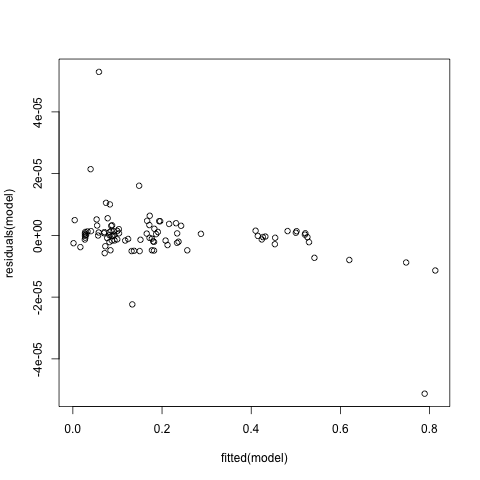

In [30]:
%%R
plot(fitted(model), residuals(model))

In [31]:
%%R
round(residuals(model), 3)*100

   dst_st_cnt_aus dst_st_cnt_can dst_st_cnt_nz dst_st_cnt_uk dst_st_cnt_us
0               0              0             0             0             0
1               0              0             0             0             0
2               0              0             0             0             0
3               0              0             0             0             0
4               0              0             0             0             0
5               0              0             0             0             0
6               0              0             0             0             0
7               0              0             0             0             0
8               0              0             0             0             0
9               0              0             0             0             0
10              0              0             0             0             0
11              0              0             0             0             0
12              0        

### GLM pairwise with Poisson

In [32]:
raw_dataframe.destination_country.unique()

array(['Australia', 'Canada', 'United Kingdom', 'New Zealand',
       'United States of America'], dtype=object)

In [33]:
raw_dataframe
src_country = 'China'
dst_country = 'United States of America'

df = raw_dataframe[(raw_dataframe.source_country == src_country) & (raw_dataframe.destination_country == dst_country)]
#df

In [34]:
%%R -i df
fit = glm(dst_st_cnt ~ dst_average_wage + dst_rate_of_one_usd
          + dst_cpi + dst_qoe_top100 + src_population + src_qoe_top500 
          + src_gni + src_gdp + src_tertiary_enrol,
         family=poisson, data=df)

#%%R
round(summary(fit)$coef, 5)

R[write to console]: Error in eval(predvars, data, env) : 
  object 'dst_rate_of_one_usd' not found
Calls: <Anonymous> ... eval -> <Anonymous> -> model.frame.default -> eval -> eval




Error in eval(predvars, data, env) : 
  object 'dst_rate_of_one_usd' not found
Calls: <Anonymous> ... eval -> <Anonymous> -> model.frame.default -> eval -> eval
